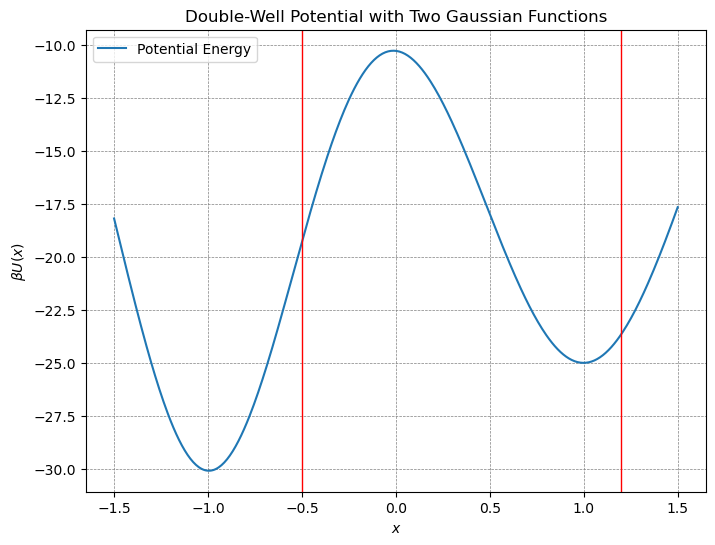

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d, PchipInterpolator, CubicSpline

# Define the double-well potential using two Gaussian functions
# def double_gaussian_potential(x, A1=3, mu1=-1, sigma1=0.5, A2=4, mu2=1, sigma2=0.6):
def double_gaussian_potential(x, A1=30, mu1=-1, sigma1=0.5, A2=25, mu2=1, sigma2=0.6):
    V1 = A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
    V2 = A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    return -(V1 + V2)
beta_U = double_gaussian_potential

D0 = 0.01
def D(x):
    # return D0*x**(2/3)
    return D0*x**0
x = np.linspace(-1.5, 1.5, 400)

# Plot the potential
plt.figure(figsize=(8, 6))
plt.plot(x, beta_U(x), label='Potential Energy')
plt.title('Double-Well Potential with Two Gaussian Functions')
plt.xlabel('$x$')
plt.ylabel(r'$\beta U(x)$')
# plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(-0.5, color='red',linewidth=1)
plt.axvline(1.2, color='red',linewidth=1)
# plt.scatter(0, beta_U(0), color='black')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

In [2]:
a = -0.5   # location of reflecting boundary
b = 1.2   # location of absorbing boundary
h = 0.01
N = int((b-a)/h+1)
x_arr = np.linspace(a, b, N)

### Steady-State Probability Distribution

#### Numerically integrate the continuous math expression (referred to be exact)

In [3]:
# Define the inner function to integrate as a function of y
def inner_integrand(y):
    return 1.0/D(y)*np.exp(beta_U(y))

# Define the inner integral as a function of x
def inner_integral(x):
    y_lower = x
    y_upper = b
    result, error = quad(inner_integrand, y_lower, y_upper)
    return result

# Define the outer integral
x_lower = a
x_upper = b

# Define the outer function to integrate (also as a function of x)
def outer_integrand(x):
    return np.exp(-beta_U(x))*inner_integral(x)

# Perform the outer integration
invert_st_flux, error = quad(outer_integrand, x_lower, x_upper)
st_flux = 1.0/invert_st_flux

In [4]:
def st_P_func(x):
    def integrand(y):
        return 1.0/D(y)*np.exp(beta_U(y))
    # Perform the integration
    y_lower = x
    y_upper = b
    result, error = quad(integrand, y_lower, y_upper)
    result *= st_flux*np.exp(-beta_U(x))
    return result

st_P_arr = np.zeros(x_arr.size)
for i in np.arange(x_arr.size):
    st_P_arr[i] = st_P_func(x_arr[i])

#### Fixed Eigenvector of the Transfer Matrix with Recycling Boundary Condition

/tmp/ipykernel_102565/1709580855.py:9: RuntimeWarning: divide by zero encountered in log
  plt.plot(x_arr, -np.log(st_P_arr), '--', label="exact")


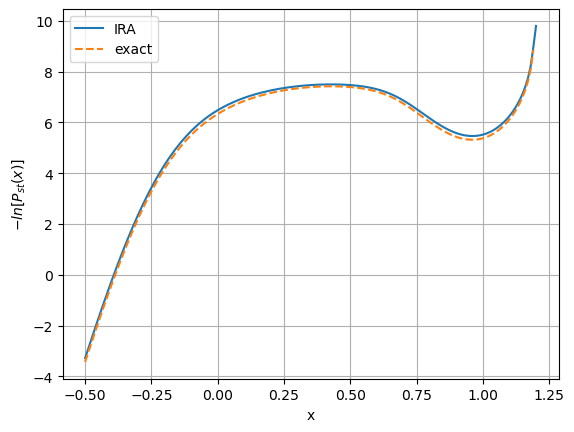

In [5]:
from transfer_matrix_reptile import TransferMatrix_InReAb

ira_trans = TransferMatrix_InReAb(h, x_arr, beta_U, 0)

# plt.plot(x_arr, ira_trans.steady_state, label="RIA")
# plt.plot(x_arr, st_P_arr, '--', label="exact")

plt.plot(x_arr, -np.log(ira_trans.steady_state), label="IRA")
plt.plot(x_arr, -np.log(st_P_arr), '--', label="exact")

plt.xlabel('x')
plt.ylabel("$-ln[P_{st}(x)]$")
plt.legend()
plt.grid()

### MFPT

#### Numerically integrate the nested integral expression (referred to be exact)

In [6]:
x0 = a   # Regura's method, overlap the starting point and reflecting boundary

# Define the inner function to integrate as a function of z
def inner_integrand(z):
    return np.exp(-beta_U(z))

# Define the inner integral as a function of y
def inner_integral(y):
    z_lower = a
    z_upper = y
    result, error = quad(inner_integrand, z_lower, z_upper)
    return result

# Define the outer integral
y_lower = x0
y_upper = b

# Define the outer function to integrate (also as a function of y)
def outer_integrand(y):
    return np.exp(beta_U(y))*inner_integral(y)/D(y)

# Perform the outer integration (from x0 to b)
result, error = quad(outer_integrand, y_lower, y_upper)

mfpt_arr = np.zeros(x_arr.size)
for i in np.arange(x_arr.size):
    mfpt_arr[i], _ = quad(outer_integrand, y_lower, x_arr[i])

#### MFPT matrix Calculated by Transfer Matrix with Recycling Boundary Condtion

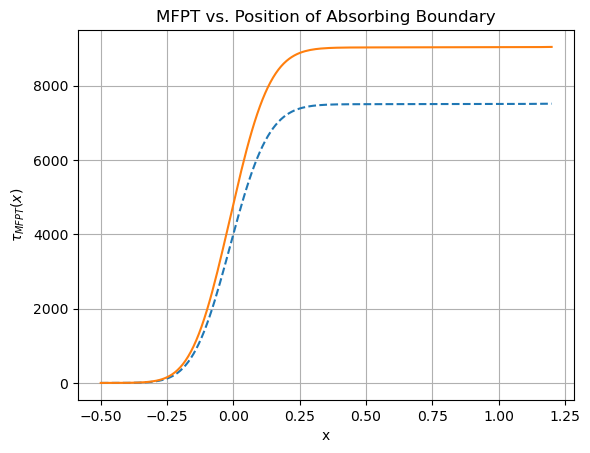

In [7]:
def mfpt_matrix(transMat_instance):
    ria_trans = transMat_instance
    ria_P = ria_trans.trans_mat.T
    idx_fixed_vect = np.where(np.round(ria_trans.eig6_w.real, decimals=10) == 1)[0][0]
    vec_pi = ria_trans.eig6_v[:,idx_fixed_vect].real/np.sum(ria_trans.eig6_v[:,idx_fixed_vect].real)
    N = vec_pi.size
    epsilon = np.ones(N)
    mat_I = np.eye(N)
    mat_E = np.ones((N, N))
    mat_Z = np.linalg.inv(mat_I-ria_P+np.outer(epsilon, vec_pi))
    vec_Zdg = np.diag(mat_Z)
    mat_Zdg = np.diag(vec_Zdg)
    mat_Mdg = np.diag(1/vec_pi)
    mat_M = (mat_I - mat_Z + mat_E @ mat_Zdg) @ mat_Mdg
    mat_Mbar = mat_M - mat_Mdg
    return mat_Mbar

m_bar = mfpt_matrix(ira_trans)
delt_t = h**2/(2*D0)

plt.xlabel('x')
plt.ylabel(r"$\tau_{MFPT} (x)$")
plt.plot(x_arr, mfpt_arr, '--')
plt.plot(x_arr, delt_t*m_bar[0], label="IRA-MFPT")
plt.title('MFPT vs. Position of Absorbing Boundary')
plt.grid()

### Define Functions for Reconstructing Free Energy with MFPT and steady state distribution

In [8]:
def reconstruct_energy_ra(x_arr, Pst_arr, mfpt_arr):
    Pst_arr[-1] = 0
    interp_Pst_func = CubicSpline(x_arr, np.array(Pst_arr, dtype=float))
    N = x_arr.size
    # Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0
    Bx_arr = np.zeros(N-2)
    integral_Pst_arr = np.zeros(N-2)
    for i in range(N-2):
        integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[1+i], x_arr[-1])
        Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]-(mfpt_arr[-1]-mfpt_arr[1+i])/mfpt_arr[-1])

    interp_invertBx_func = CubicSpline(x_arr[1:-1], 1.0/Bx_arr)
    integral_invertBx_arr = np.zeros(N-2)
    beta_Grec2_arr = np.zeros(N-2)
    for i in range(N-2):
        # Here x0 is x_arr[1]
        integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
        beta_Grec2_arr[i] = beta_U(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]
    return beta_Grec2_arr

def reconstruct_energy_ar(x_arr, Pst_arr, mfpt_arr):
    Pst_arr[0] = 0
    interp_Pst_func = CubicSpline(x_arr, np.array(Pst_arr, dtype=float))
    N = x_arr.size
    # Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0
    Bx_arr = np.zeros(N-2)
    integral_Pst_arr = np.zeros(N-2)
    for i in range(N-2):
        integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[0], x_arr[1+i])
        Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]+(mfpt_arr[1+i]-mfpt_arr[0])/mfpt_arr[0])

    interp_invertBx_func = CubicSpline(x_arr[1:-1], 1.0/Bx_arr)
    integral_invertBx_arr = np.zeros(N-2)
    beta_Grec2_arr = np.zeros(N-2)
    for i in range(N-2):
        # Here x0 is x_arr[1]
        integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1+i], x_arr[-2])
        beta_Grec2_arr[i] = beta_U(x_arr[-2])+np.log(Bx_arr[i]/Bx_arr[-1])-integral_invertBx_arr[i]
    return beta_Grec2_arr

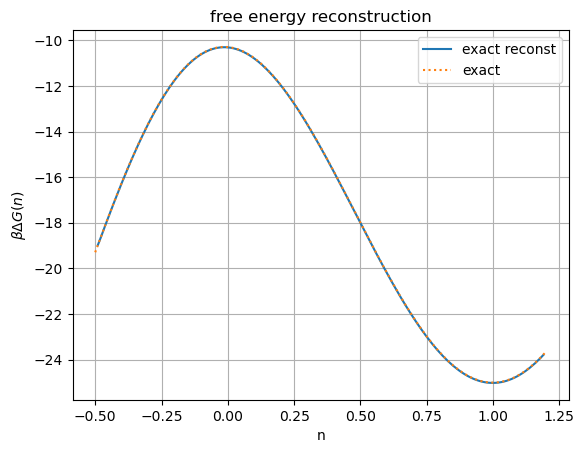

In [9]:
exact_beta_Grec2_arr = reconstruct_energy_ra(x_arr, Pst_arr=st_P_arr, mfpt_arr=mfpt_arr)

plt.plot(x_arr[1:-1], exact_beta_Grec2_arr, label="exact reconst")
plt.plot(x_arr, beta_U(x_arr), ':', label="exact")
# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

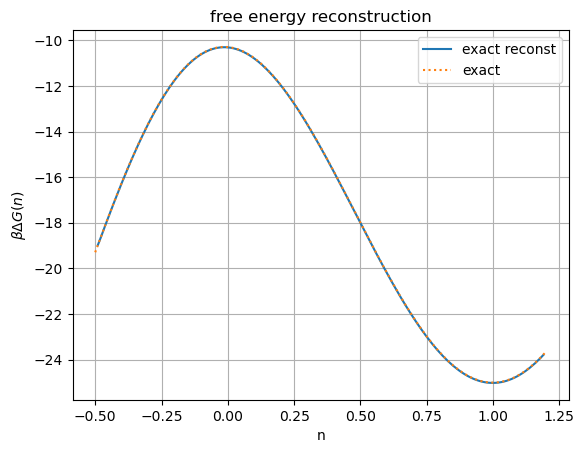

In [10]:
beta_Grec2_arr = reconstruct_energy_ra(x_arr, Pst_arr=ira_trans.steady_state.real, mfpt_arr=m_bar[0])
plt.plot(x_arr[1:-1], exact_beta_Grec2_arr, label="exact reconst")
plt.plot(x_arr, beta_U(x_arr), ':', label="exact")
# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()